In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from numpy.random import normal

In [6]:
temps = normal(22, 1, 1000)

(array([ 22.,  67., 102., 221., 226., 197., 114.,  33.,  14.,   4.]),
 array([19.34965351, 19.9524671 , 20.5552807 , 21.1580943 , 21.7609079 ,
        22.36372149, 22.96653509, 23.56934869, 24.17216228, 24.77497588,
        25.37778948]),
 <a list of 10 Patch objects>)

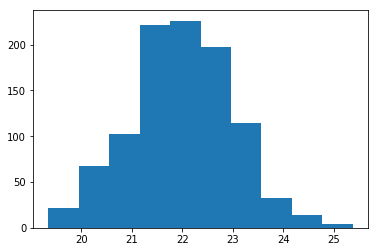

In [7]:
hist(temps)

In [8]:
from random import Random

In [9]:
rnd = Random()

In [12]:
temps = [rnd.normalvariate(22, 0.5) for _ in range(1000)]

(array([  3.,  25.,  86., 162., 251., 245., 154.,  51.,  21.,   2.]),
 array([20.45294826, 20.77438649, 21.09582471, 21.41726294, 21.73870116,
        22.06013939, 22.38157761, 22.70301584, 23.02445406, 23.34589229,
        23.66733051]),
 <a list of 10 Patch objects>)

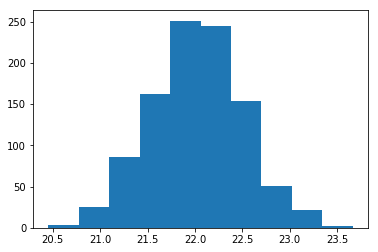

In [13]:
hist(temps)

In [89]:
P = array([[0, 1, 0],[1/6,2/3,1/6],[2/3,0,1/3]])

In [80]:
np.linalg.eig(P)[1][0]/sum(np.linalg.eig(P)[1][0])

array([0.40550952-0.j        , 0.29724524-0.21018412j,
       0.29724524+0.21018412j])

In [86]:
P = array([[0.6, 0.4, 0],[0.6,0.4,0.0],[0.5,0.5,0.0]])

In [95]:
def eiv(P):
    S, U = np.linalg.eig(P.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return real(stationary) 

In [118]:
default_control = [
    array([[0.8, 0.2, 0.], [0.8, 0.2, 0.], [0.8, 0.2, 0]]),
    array([[0.2, 0.8, 0.], [0.2, 0.8, 0.], [0.2, 0.8, 0]]),
    array([[0.2, 0., 0.8], [0.5, 0., 0.5], [0.2, 0., 0.8]]),
    array([[0.5, 0.25, 0.25], [0., 0.3, 0.7], [0.3, 0.0, 0.7]]),
    array([[0.9, 0.1, 0.], [0.1, 0.9, 0], [0.5, 0.5, 0]]),
    array([[0.7, 0.3, 0.], [0., 0.7, 0.3], [0.3, 0., 0.7]])
]
q = array([0, 1, 2])
environment_temp = lambda t: 18 + 2*np.sin(2*np.pi/24*t)
 
thermal_coefficent = lambda t: 4
temps = lambda t: [environment_temp(t) + thermal_coefficent(t)*q.T.dot(eiv(x)) for x in default_control]
omega = lambda t: [[np.abs(temps(t)[i] - temps(t)[j]) < 2 and temps(t)[i] > 17 and temps(t)[i]<26
                    for j in range(len(default_control))] for i in range(len(default_control))]

In [119]:
import seaborn as sns

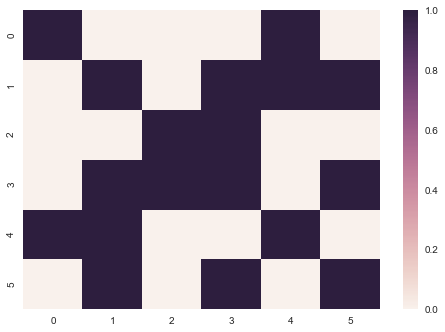

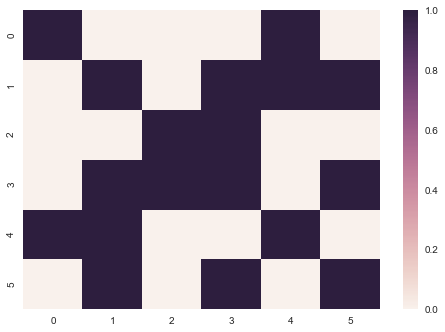

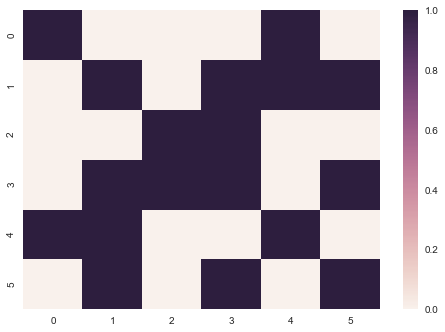

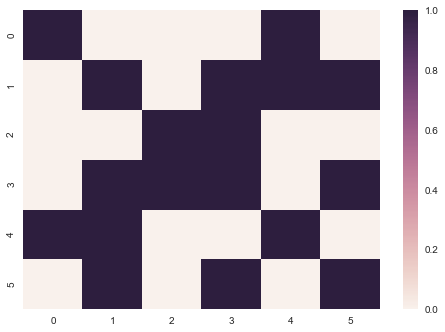

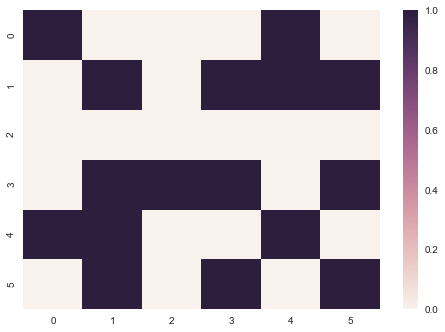

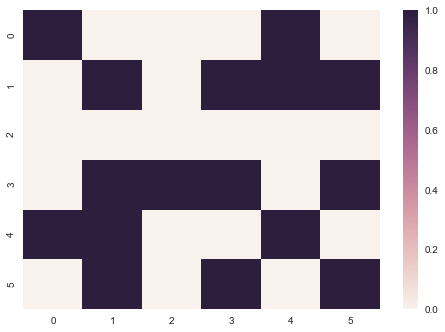

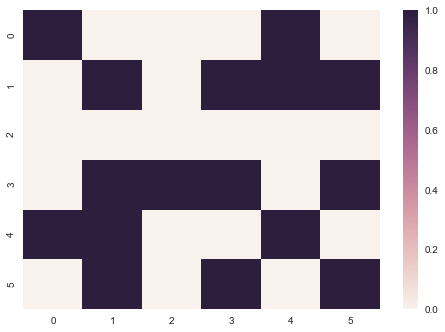

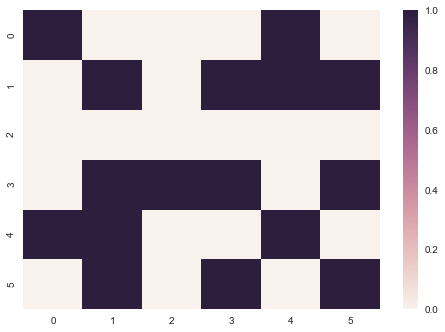

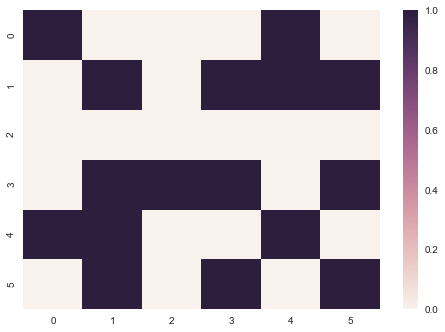

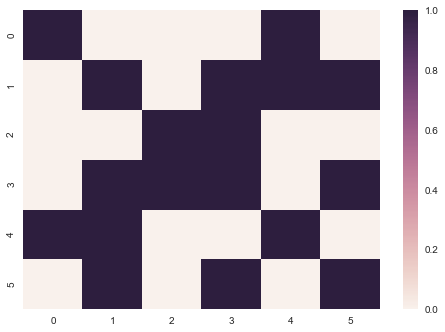

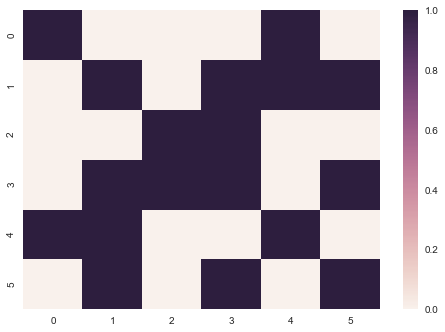

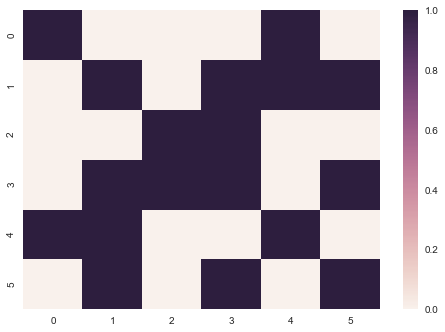

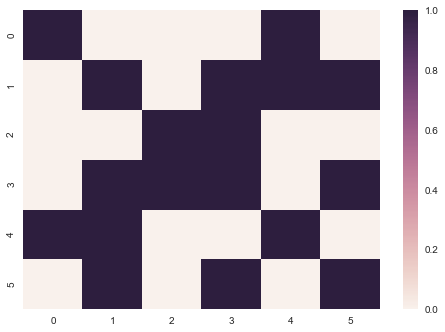

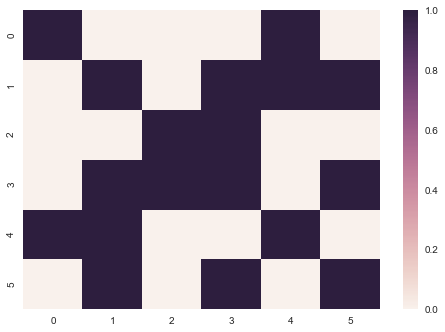

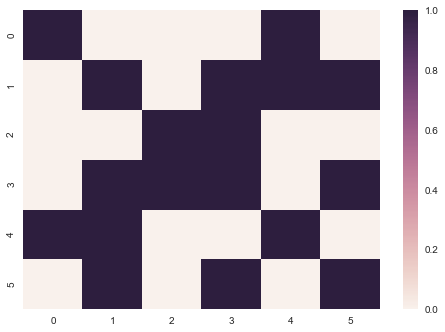

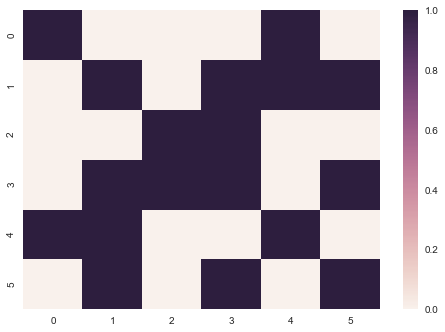

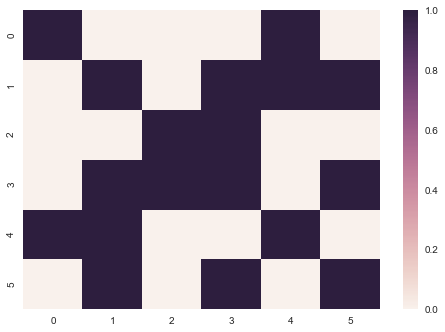

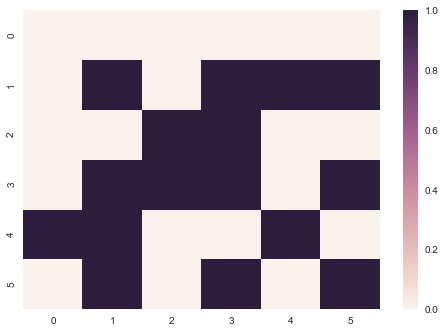

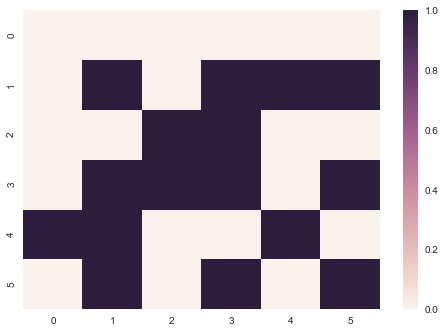

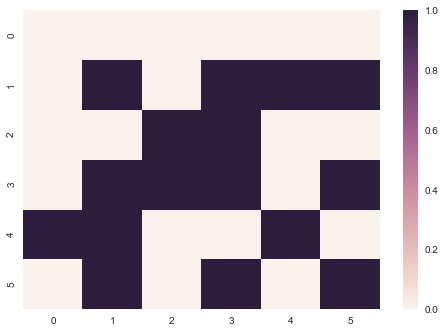

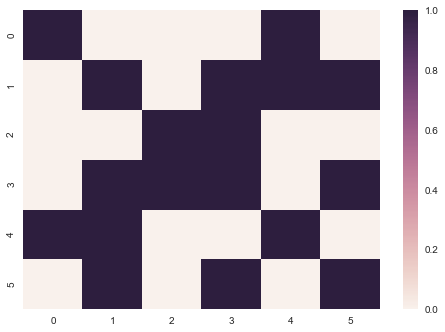

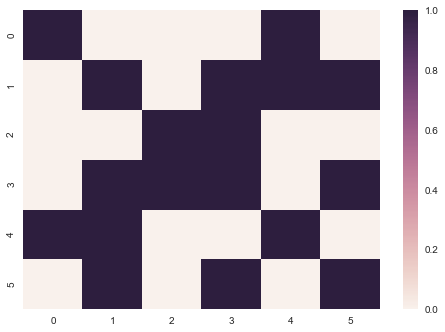

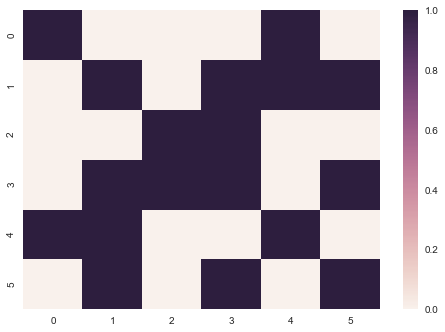

In [121]:
for t in range(23):
    sns.heatmap(omega(t))
    plt.show()

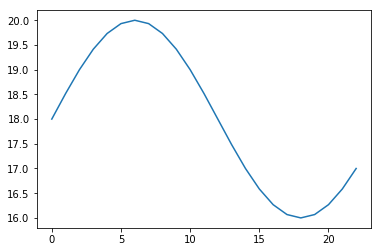

In [112]:
plot([environment_temp(t) for t in range(23)])

In [62]:
P = array([[1/3, 2/3], [1/3, 2/3]])

In [63]:
u = np.linalg.eig(P.T)[1][0]
u/sum(u)

array([0.61257411, 0.38742589])

In [104]:
eiv(array([[0.2, 0., 0.8], [0.5, 0., 0.5], [0.2, 0., 0.8]]),)

array([ 0.2, -0. ,  0.8])